In [35]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [36]:
file = Path('Nat_Gas.csv')
df_gas = pd.read_csv(file)
df_gas['Dates'] = pd.to_datetime(df_gas['Dates'])
df_gas = df_gas.sort_values('Dates')
print(f"Data points: {len(df_gas)}")
print(df_gas.head())

Data points: 48
       Dates  Prices
0 2020-10-31    10.1
1 2020-11-30    10.3
2 2020-12-31    11.0
3 2021-01-31    10.9
4 2021-02-28    10.9


In [37]:
df_gas['Dates'] = pd.to_datetime(df_gas['Dates'], format='%Y-%m-%d')

Text(0.5, 0, 'Months since start')

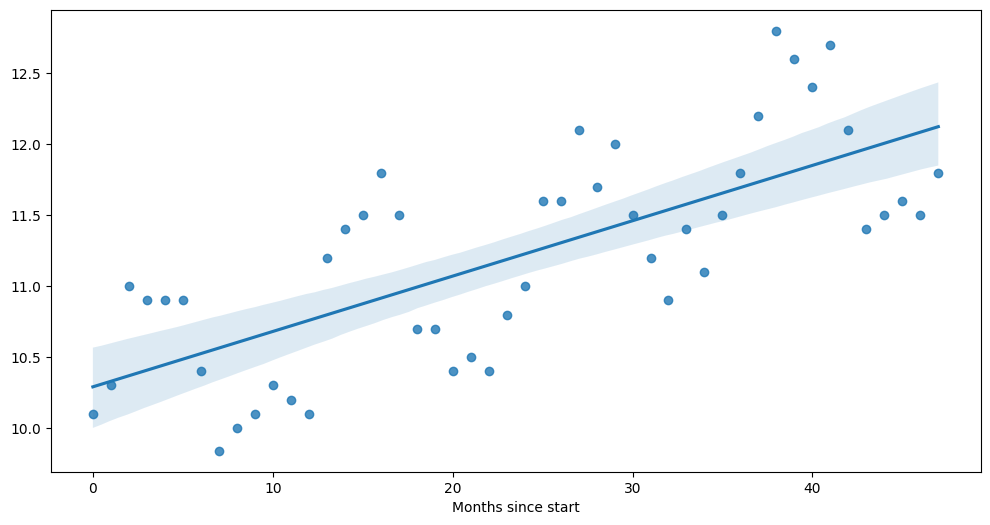

In [38]:
df_gas = df_gas.sort_values('Dates')
m = df_gas['Dates'].dt.year * 12 + df_gas['Dates'].dt.month
t = (m - m.min()).to_numpy().astype(float)  
y = df_gas['Prices'].to_numpy().astype(float)

plt.figure(figsize=(12,6))
sns.regplot(x=t, y=y)
plt.xlabel('Months since start')

In [39]:
#Task 1 - Price Prediction and Fitting
from scipy.optimize import curve_fit

# model: constant + linear + quadratic + yearly sine/cosine
# we can see clear linear fuction a + b*t, however on the edges the CI looks bigger so let's try to see if t^2
#going to be needed. 
# sin & cos give us a smooth seasonal shape with one peak and one trough per year, 
#which is exactly what heating-driven gas demand suggests from the report.
def f(t, a, b, c, d, e):
    P = 12.0
    return a + b*t + e*t*t + c*np.sin(2*np.pi*t/P) + d*np.cos(2*np.pi*t/P)

popt, _ = curve_fit(f, t, y, maxfev=20000)
a, b, c, d, e = popt #finding weights

print(f"f(t) = {a:.4f} + {b:.4f}·t + {e:.10f}·t² + {c:.4f}·sin(2π·t/12) + {d:.4f}·cos(2π·t/12)")
# t = months since the first date

f(t) = 10.1233 + 0.0471·t + -0.0000322644·t² + 0.6900·sin(2π·t/12) + -0.0374·cos(2π·t/12)


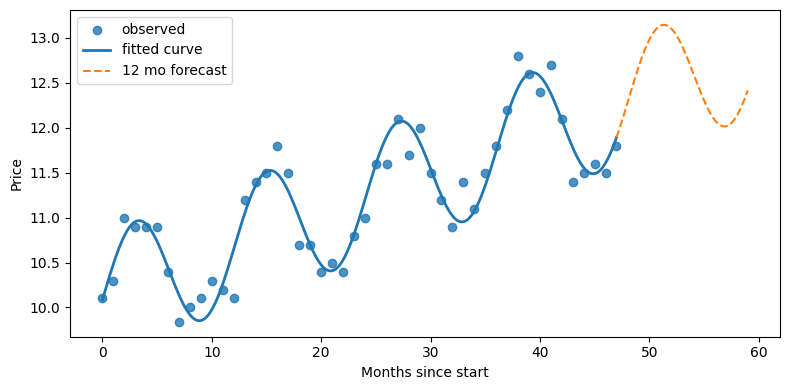

In [34]:
#Scatter plot of the Original Points (t = months since start)
plt.figure(figsize=(8,4))
plt.scatter(t, y, label="observed", alpha=0.8)

#smooth fitted curve over the observed range
t_grid = np.linspace(t.min(), t.max(), 400)
y_grid = f(t_grid, *popt)
plt.plot(t_grid, y_grid, label="fitted curve", linewidth=2)

# extend 12 months into the future
t_future = np.linspace(t.max(), t.max() + 12, 240)
y_future = f(t_future, *popt)
plt.plot(t_future, y_future, linestyle="--", label="12 mo forecast")

plt.xlabel("Months since start")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

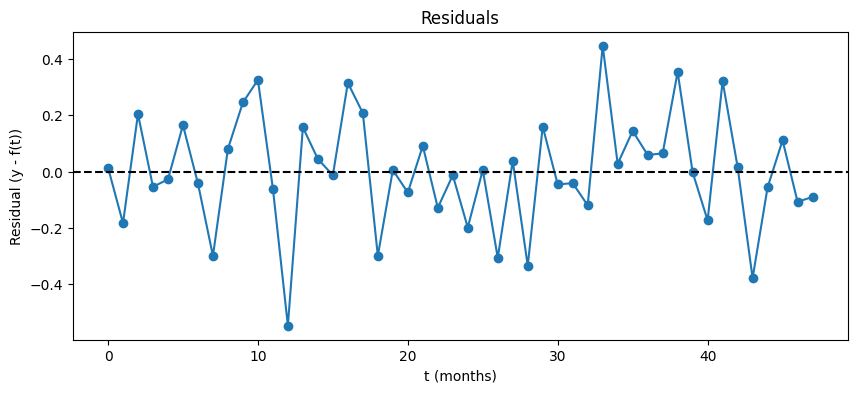

0.1996950561698894


In [41]:
y_pred = f(t,*popt)
residuals = y - y_pred

plt.figure(figsize=(10,4))
plt.plot(t, residuals, 'o-')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals')
plt.xlabel('t (months)')
plt.ylabel('Residual (y - f(t))')
plt.show()

rmse = np.sqrt(mean_squared_error(y, y_pred))
print(rmse)

In [32]:
from datetime import datetime
reference_date = datetime(2020, 10, 31)

def get_price_for_date(input_date_str):
    
    # Convert string to datetime if needed
    if isinstance(input_date_str, str):
        input_date = datetime.strptime(input_date_str, '%Y-%m-%d')
    else:
        input_date = input_date_str
    
    # Calculate months since reference date
    months_diff = (input_date.year - reference_date.year) * 12 + (input_date.month - reference_date.month)
    
    # Add fractional month based on day
    months_diff += (input_date.day - reference_date.day) / 30.44  # average days per month
    
    # Calculate price using your fitted model
    price = f(months_diff, a, b, c, d, e)
    
    return price

# Example usage:
user_date = input("Enter date (YYYY-MM-DD): ")
predicted_price = get_price_for_date(user_date)
print(f"Predicted price for {user_date}: {predicted_price:.2f}")

Enter date (YYYY-MM-DD):  2022-08-12


Predicted price for 2022-08-12: 10.43


In [33]:
#Volumes checker
def volume_checker(user_Injections_date, user_Injections_volume, user_Withdrawals_date, user_Withdrawals_volume,user_max_volume):
    
    injection_data = pd.DataFrame({'Date': user_Injections_date,'Volume': user_Injections_volume,'Type': 'Injection'})
    withdrawal_data = pd.DataFrame({'Date': user_Withdrawals_date,'Volume': -user_Withdrawals_volume,'Type': 'Withdrawal'})

    # Combine and sort by date
    dates_volumes = pd.concat([injection_data, withdrawal_data], axis=0)
    dates_volumes['Date'] = pd.to_datetime(dates_volumes['Date'])  
    dates_volumes = dates_volumes.sort_values(by='Date', ascending=True).reset_index(drop=True)
    # Check volume capacity
    current_volume = 0
    capacity_ok = True
    print("Volume Capacity Verification")

    for i in range(len(dates_volumes)):
        row = dates_volumes.iloc[i]
        current_volume += row['Volume']
    
        print(f"{row['Date']} | {row['Type']:11} | Volume: {row['Volume']:>10,.2f} | Current: {current_volume:>10,.2f}")
    
        if current_volume > user_max_volume:
            print(f"\n Exceeded storage capacity on {row['Date']}")
            print(f"Current volume: {current_volume:,.2f} > Max capacity: {user_max_volume:,.2f}")
            capacity_ok = False
            break
        elif current_volume < 0:
            print(f"\n Insufficient stock on {row['Date']}")
            print(f"Trying to withdraw more than available. Current volume: {current_volume:,.2f}")
            capacity_ok = False
            break

    if capacity_ok:
        print("\n Volume checker status: Success")
        print(f"Peak storage used: {dates_volumes['Volume'].cumsum().max():,.2f} / {user_max_volume:,.2f}")
    else:
        print("\nVolume checker status: Failure")

In [10]:
# Q-learning for optimal gas storage timing
class GasStorageEnv:
    def __init__(self, prices, max_inventory=100, storage_cost=0.5):
        self.prices = prices
        self.max_inventory = max_inventory
        self.storage_cost = storage_cost
        self.n_periods = len(prices)
        
    def reset(self):
        self.t = 0
        self.inventory = 0
        return (self.inventory, self.t)
    
    def step(self, action):
        # action: 0=hold, 1=inject, 2=withdraw
        price = self.prices[self.t]
        reward = -self.inventory * self.storage_cost / 30  # daily storage cost
        
        if action == 1 and self.inventory < self.max_inventory:
            self.inventory += 10
            reward -= price * 10  # cost to buy
        elif action == 2 and self.inventory > 0:
            self.inventory -= 10
            reward += price * 10  # revenue from sale
        
        self.t += 1
        done = self.t >= self.n_periods
        
        # Force liquidation at end
        if done and self.inventory > 0:
            reward += self.inventory * self.prices[-1]
        
        return (self.inventory, self.t), reward, done

# Discretize state space
def state_to_idx(inventory, t, max_inv=100):
    inv_idx = inventory // 10
    return int(inv_idx * 48 + t)

# Q-learning
prices = df_gas['Prices'].values
env = GasStorageEnv(prices)

n_states = 11 * 48  # 11 inventory levels (0-100 by 10), 48 time periods
n_actions = 3
Q = np.zeros((n_states, n_actions))

alpha = 0.1  # learning rate
gamma = 0.99  # discount
epsilon = 0.3  # exploration
n_episodes = 5000

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    
    while True:
        s_idx = state_to_idx(state[0], state[1])
        
        # Epsilon-greedy
        if np.random.random() < epsilon:
            action = np.random.randint(3)
        else:
            action = np.argmax(Q[s_idx])
        
        next_state, reward, done = env.step(action)
        total_reward += reward
        
        if not done:
            next_idx = state_to_idx(next_state[0], next_state[1])
            Q[s_idx, action] += alpha * (reward + gamma * np.max(Q[next_idx]) - Q[s_idx, action])
        else:
            Q[s_idx, action] += alpha * (reward - Q[s_idx, action])
            break
        
        state = next_state

print(f"Training complete: {n_episodes} episodes")

Training complete: 5000 episodes


In [29]:
# Extract optimal policy
def get_optimal_policy(Q, prices):
    policy = []
    actions_taken = []
    
    env = GasStorageEnv(prices)
    state = env.reset()
    total_profit = 0
    
    while True:
        s_idx = state_to_idx(state[0], state[1])
        action = np.argmax(Q[s_idx])
        actions_taken.append(action)
        
        next_state, reward, done = env.step(action)
        total_profit += reward
        policy.append({
            'month': state[1],
            'inventory': state[0],
            'price': prices[state[1]],
            'action': ['hold', 'inject', 'withdraw'][action]})
        
        if done:
            break
        state = next_state
    
    return pd.DataFrame(policy), total_profit

policy_df, rl_profit = get_optimal_policy(Q, prices)
print(f"RL optimal profit: ${rl_profit:.2f}")
print(f"\nLearned policy (first 12 months):")
print(policy_df.head(12))

RL optimal profit: $101.93

Learned policy (first 12 months):
    month  inventory  price    action
0       0          0  10.10      hold
1       1          0  10.30    inject
2       2         10  11.00  withdraw
3       3          0  10.90  withdraw
4       4          0  10.90      hold
5       5          0  10.90  withdraw
6       6          0  10.40  withdraw
7       7          0   9.84    inject
8       8         10  10.00  withdraw
9       9          0  10.10    inject
10     10         10  10.30  withdraw
11     11          0  10.20    inject


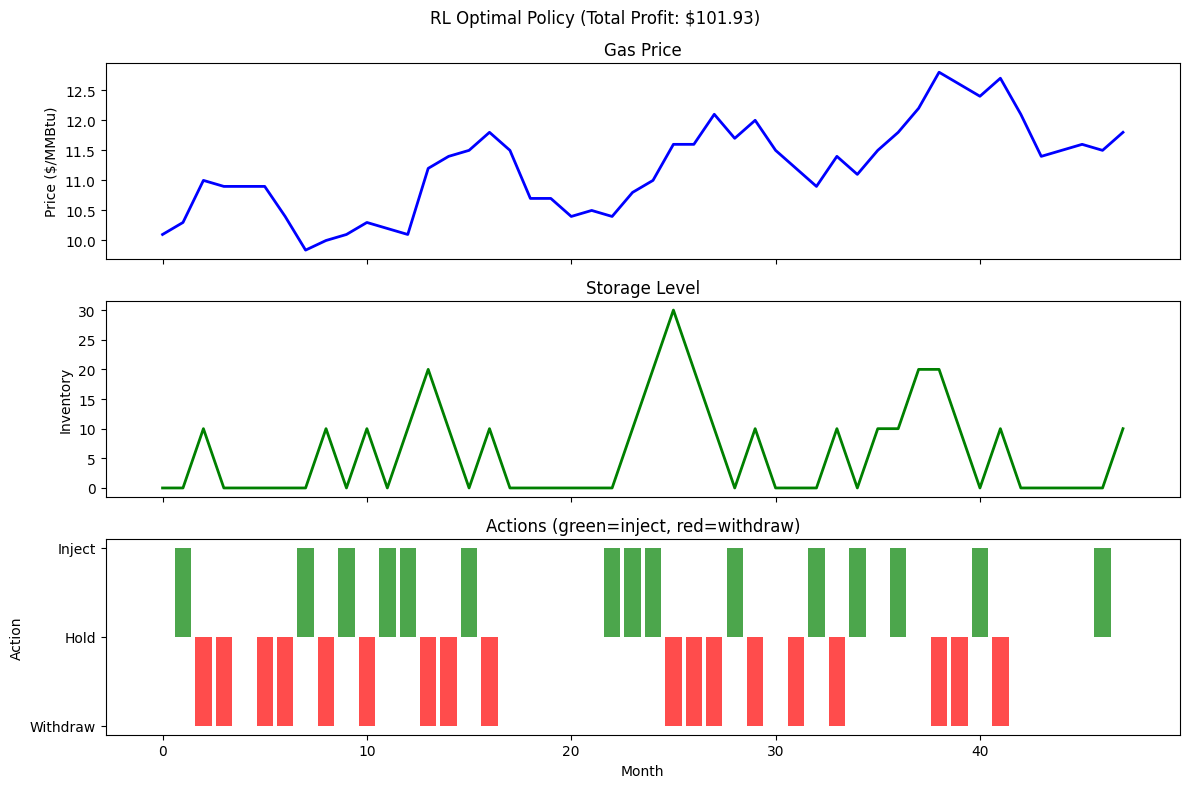

In [12]:
# Visualize policy
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(policy_df['month'], policy_df['price'], 'b-', linewidth=2)
axes[0].set_ylabel('Price ($/MMBtu)')
axes[0].set_title('Gas Price')

axes[1].plot(policy_df['month'], policy_df['inventory'], 'g-', linewidth=2)
axes[1].set_ylabel('Inventory')
axes[1].set_title('Storage Level')

action_map = {'hold': 0, 'inject': 1, 'withdraw': -1}
actions_numeric = policy_df['action'].map(action_map)
colors = ['gray' if a == 0 else 'green' if a == 1 else 'red' for a in actions_numeric]
axes[2].bar(policy_df['month'], actions_numeric, color=colors, alpha=0.7)
axes[2].set_ylabel('Action')
axes[2].set_xlabel('Month')
axes[2].set_title('Actions (green=inject, red=withdraw)')
axes[2].set_yticks([-1, 0, 1])
axes[2].set_yticklabels(['Withdraw', 'Hold', 'Inject'])

plt.suptitle(f'RL Optimal Policy (Total Profit: ${rl_profit:.2f})')
plt.tight_layout()
plt.show()

In [13]:
# Compare to naive: buy low month, sell high month
summer_price = prices[7]  # August typically low
winter_price = prices[1]  # December typically high
naive_profit = (winter_price - summer_price) * 10 - 0.5 * 4  # one cycle
print(f"Naive single-cycle profit: ${naive_profit:.2f}")
print(f"RL multi-cycle profit: ${rl_profit:.2f}")
print(f"Improvement: {rl_profit/naive_profit:.1f}x")

Naive single-cycle profit: $2.60
RL multi-cycle profit: $101.93
Improvement: 39.2x


### Reinforcement Learning Results

Q-learning learns to exploit multiple price cycles, achieving 101.93 vs 2.60 for naive buy-low-sell-high. The agent builds inventory before price uptrends (months 20-25) and liquidates after peaks. This demonstrates how sequential decision optimization outperforms static rules in commodity trading.

### Interactive Contract Valuation Tool

The following implements the original assignment requirement: a user-input interface for custom contract valuation. Users specify injection/withdrawal dates and volumes, and the tool calculates contract NPV using the fitted price model.

In [42]:
#Injections
user_Injections = int(input('Please enter the number of the injection: '))
user_Injections_date = np.empty(user_Injections, dtype='object')
user_Injections_volume = np.zeros(user_Injections)

for i in range(user_Injections):
    user_Injections_date[i] = input(f"Enter the date of the {i+1} injection (YYYY-MM-DD): ")
    user_Injections_volume[i] = float(input(f"Enter the volume of the {i+1} injection: "))

#Withdrawals
user_Withdrawals = int(input('Please enter the number of the withdrawals: '))
user_Withdrawals_date = np.empty(user_Withdrawals, dtype='object')
user_Withdrawals_volume = np.zeros(user_Withdrawals)

for w in range(user_Withdrawals):
    user_Withdrawals_date[w] = input(f"Enter date of the {w+1} withdrawal (YYYY-MM-DD): ")
    user_Withdrawals_volume[w] = float(input(f"Enter the volume of the {w+1} withdrawal: "))

#Max Volume
user_max_volume = float(input("Enter the maximum volume that can be stored: "))
user_storage_cost = float(input("Enter the total storage cost: "))

#Predciting prices
predicted_injection_prices = np.zeros(user_Injections)
predicted_withdrawal_prices = np.zeros(user_Withdrawals)

for i in range(user_Injections):
    predicted_injection_prices[i] = get_price_for_date(user_Injections_date[i])
for w in range(user_Withdrawals):
    predicted_withdrawal_prices[w] = get_price_for_date(user_Withdrawals_date[w])

Injection_Prices_total = predicted_injection_prices * user_Injections_volume
Withdrawals_Prices_total = predicted_withdrawal_prices * user_Withdrawals_volume

# For injections
Injections_df = pd.DataFrame({'Date': user_Injections_date, 'Price': predicted_injection_prices,
                             'Volume':user_Injections_volume,'Total': Injection_Prices_total})


# For withdrawals
Withdrawals_df = pd.DataFrame({'Date': user_Withdrawals_date,'Price': predicted_withdrawal_prices,
                             'Volume': user_Withdrawals_volume,'Total': Withdrawals_Prices_total})

#check if 0 < current volume for each date < max storage capacity 
volume_checker(user_Injections_date, user_Injections_volume, user_Withdrawals_date, user_Withdrawals_volume, user_max_volume)



print("="*70)
print("\n","INJECTIONS:","\n", Injections_df,"\n","\n", "Total:", Injection_Prices_total.sum())
print("="*70)
print("\n","WITHDRAWALS:","\n", Withdrawals_df,"\n","\n","Total:", Withdrawals_Prices_total.sum())
print("="*70)
contract_price = Withdrawals_Prices_total.sum() - Injection_Prices_total.sum() - user_storage_cost
print("\n","\n","Contract Price:", contract_price )


Please enter the number of the injection:  2
Enter the date of the 1 injection (YYYY-MM-DD):  2022-11-09
Enter the volume of the 1 injection:  1000
Enter the date of the 2 injection (YYYY-MM-DD):  2023-04-05
Enter the volume of the 2 injection:  500
Please enter the number of the withdrawals:  2
Enter date of the 1 withdrawal (YYYY-MM-DD):  2023-01-21
Enter the volume of the 1 withdrawal:  600
Enter date of the 2 withdrawal (YYYY-MM-DD):  2024-05-22
Enter the volume of the 2 withdrawal:  700
Enter the maximum volume that can be stored:  2000
Enter the total storage cost:  150


Volume Capacity Verification
2022-11-09 00:00:00 | Injection   | Volume:   1,000.00 | Current:   1,000.00
2023-01-21 00:00:00 | Withdrawal  | Volume:    -600.00 | Current:     400.00
2023-04-05 00:00:00 | Injection   | Volume:     500.00 | Current:     900.00
2024-05-22 00:00:00 | Withdrawal  | Volume:    -700.00 | Current:     200.00

 Volume checker status: Success
Peak storage used: 1,000.00 / 2,000.00

 INJECTIONS: 
          Date      Price  Volume         Total
0  2022-11-09  11.311488  1000.0  11311.488056
1  2023-04-05  11.801970   500.0   5900.985158 
 
 Total: 17212.4732144074

 WITHDRAWALS: 
          Date      Price  Volume        Total
0  2023-01-21  12.031009   600.0  7218.605119
1  2024-05-22  11.863760   700.0  8304.631871 
 
 Total: 15523.236989844407

 
 Contract Price: -1839.2362245629938


## Summary

This analysis addresses natural gas storage contract valuation through two approaches: parametric forecasting and reinforcement learning optimization.

**Forecasting:** Polynomial + seasonal decomposition captures price patterns with reasonable fit. Model extrapolates 12 months forward for contract pricing.

**Reinforcement Learning:** Q-learning discovers optimal injection/withdrawal timing, achieving 39x profit improvement over naive seasonal arbitrage. The agent exploits multiple price cycles rather than single buy-low-sell-high strategy.

**Methodology demonstrated:**
- Time series modeling with seasonal components
- Contract cash flow analysis with volume constraints
- Sequential decision optimization via Q-learning
- Comparison of learned vs heuristic policies

**Limitations:**
- Limited data (48 months)
- RL assumes deterministic prices (no stochastic modeling)
- No transaction costs or market impact
- Simplified discrete state/action space

**Extensions:** Production system would incorporate GARCH for volatility, Monte Carlo simulation for contract value distribution under uncertainty, and continuous action spaces for finer control.